In [124]:
# Cell 1: Imports and Setup
import sys
import os
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gzip
from IPython.display import Image, display
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))
from openstl.models import SimVP_Model

device = torch.device('mps' if torch.backends.mps.is_available() else 
                      'cuda' if torch.cuda.is_available() else 'cpu')

In [125]:
# Cell 2: Load Model
model = SimVP_Model(
    in_shape=(10, 1, 64, 64),
    hid_S=16,
    hid_T=256,
    N_S=4,
    N_T=4,
    model_type='gSTA',
    spatio_kernel_enc=3,
    spatio_kernel_dec=3,
)

ckpt_path = 'work_dirs/simvp_gsta_mmnist_m2/checkpoints/best.ckpt'
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state_dict = ckpt['state_dict']
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('model.'):
            new_state_dict[k[6:]] = v
        else:
            new_state_dict[k] = v
    model.load_state_dict(new_state_dict)

model = model.to(device)
model.eval()

SimVP_Model(
  (enc): Encoder(
    (enc): Sequential(
      (0): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): SiLU()
        )
      )
      (1): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): SiLU()
        )
      )
      (2): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): SiLU()
        )
      )
      (3): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): SiLU()
        )
      )
    )
  )
  (de

In [126]:
# Cell 3: Data Generation Functions
def load_mnist_digits():
    path = "../data/moving_mnist/train-images-idx3-ubyte.gz"
    with gzip.open(path, 'rb') as f:
        mnist = np.frombuffer(f.read(), np.uint8, offset=16)
        mnist = mnist.reshape(-1, 28, 28)
    return mnist

def generate_trajectory(seq_length, step_length, initial_pos, initial_vel, canvas_size=36):
    x, y = initial_pos
    vx, vy = initial_vel
    
    positions_x = np.zeros(seq_length)
    positions_y = np.zeros(seq_length)
    
    for i in range(seq_length):
        x += vx * step_length
        y += vy * step_length
        
        if x <= 0:
            x = 0
            vx = -vx
        if x >= 1.0:
            x = 1.0
            vx = -vx
        if y <= 0:
            y = 0
            vy = -vy
        if y >= 1.0:
            y = 1.0
            vy = -vy
            
        positions_x[i] = x * canvas_size
        positions_y[i] = y * canvas_size
    
    return positions_x.astype(np.int32), positions_y.astype(np.int32)

def create_moving_mnist_sequence(digit_indices, initial_positions, initial_velocities, 
                                step_length=0.1, seq_length=20, image_size=64):
    mnist = load_mnist_digits()
    canvas_size = image_size - 28
    
    sequence = np.zeros((seq_length, image_size, image_size), dtype=np.float32)
    
    for digit_idx, init_pos, init_vel in zip(digit_indices, initial_positions, initial_velocities):
        digit_image = mnist[digit_idx].astype(np.float32) / 255.0
        pos_x, pos_y = generate_trajectory(seq_length, step_length, init_pos, init_vel, canvas_size)
        
        for t in range(seq_length):
            top = pos_y[t]
            left = pos_x[t]
            bottom = min(top + 28, image_size)
            right = min(left + 28, image_size)
            
            digit_top = 0
            digit_left = 0
            digit_bottom = bottom - top
            digit_right = right - left
            
            if top < 0:
                digit_top = -top
                top = 0
            if left < 0:
                digit_left = -left
                left = 0
                
            sequence[t, top:bottom, left:right] = np.maximum(
                sequence[t, top:bottom, left:right],
                digit_image[digit_top:digit_bottom, digit_left:digit_right]
            )
    
    return sequence

In [127]:
# Cell 4: Create Variants
def create_all_variants_same_sample(num_samples=3):
    np.random.seed(42)
    all_samples = []
    
    for sample_idx in range(num_samples):
        num_digits = 2
        digit_indices = np.random.randint(0, 10000, num_digits)
        initial_positions = [(np.random.random(), np.random.random()) for _ in range(num_digits)]
        
        initial_velocities = []
        for _ in range(num_digits):
            theta = np.random.random() * 2 * np.pi
            initial_velocities.append((np.cos(theta), np.sin(theta)))
        
        variants = {}
        
        variants['Standard'] = create_moving_mnist_sequence(
            digit_indices, initial_positions, initial_velocities, 
            step_length=0.1, seq_length=20
        )
        
        variants['Fast_1.5x'] = create_moving_mnist_sequence(
            digit_indices, initial_positions, initial_velocities,
            step_length=0.15, seq_length=20
        )
        
        variants['Fast_2x'] = create_moving_mnist_sequence(
            digit_indices, initial_positions, initial_velocities,
            step_length=0.2, seq_length=20
        )
        
        variants['Fast_3x'] = create_moving_mnist_sequence(
            digit_indices, initial_positions, initial_velocities,
            step_length=0.3, seq_length=20
        )
        
        three_digit_indices = np.append(digit_indices, np.random.randint(0, 10000))
        three_positions = initial_positions + [(np.random.random(), np.random.random())]
        theta = np.random.random() * 2 * np.pi
        three_velocities = initial_velocities + [(np.cos(theta), np.sin(theta))]
        
        variants['Three_Digits'] = create_moving_mnist_sequence(
            three_digit_indices, three_positions, three_velocities,
            step_length=0.1, seq_length=20
        )
        
        all_samples.append(variants)
    
    return all_samples

In [128]:
# Cell 5: Metrics Calculation Functions
def calculate_metrics(pred, true):
    """Calculate MSE, MAE, PSNR, SSIM for each frame"""
    num_frames = pred.shape[0]
    metrics = {
        'mse': np.zeros(num_frames),
        'mae': np.zeros(num_frames),
        'psnr': np.zeros(num_frames),
        'ssim': np.zeros(num_frames)
    }
    
    for t in range(num_frames):
        pred_frame = pred[t, 0]  # (H, W)
        true_frame = true[t, 0]  # (H, W)
        
        # MSE
        metrics['mse'][t] = np.mean((pred_frame - true_frame) ** 2)
        
        # MAE
        metrics['mae'][t] = np.mean(np.abs(pred_frame - true_frame))
        
        # PSNR
        metrics['psnr'][t] = psnr(true_frame, pred_frame, data_range=1.0)
        
        # SSIM
        metrics['ssim'][t] = ssim(true_frame, pred_frame, data_range=1.0)
    
    return metrics

def aggregate_metrics(all_metrics):
    """Aggregate metrics across samples"""
    num_samples = len(all_metrics)
    num_frames = len(all_metrics[0]['mse'])
    
    aggregated = {
        'mse_mean': np.zeros(num_frames),
        'mse_std': np.zeros(num_frames),
        'mae_mean': np.zeros(num_frames),
        'mae_std': np.zeros(num_frames),
        'psnr_mean': np.zeros(num_frames),
        'psnr_std': np.zeros(num_frames),
        'ssim_mean': np.zeros(num_frames),
        'ssim_std': np.zeros(num_frames)
    }
    
    for t in range(num_frames):
        mse_values = [m['mse'][t] for m in all_metrics]
        mae_values = [m['mae'][t] for m in all_metrics]
        psnr_values = [m['psnr'][t] for m in all_metrics]
        ssim_values = [m['ssim'][t] for m in all_metrics]
        
        aggregated['mse_mean'][t] = np.mean(mse_values)
        aggregated['mse_std'][t] = np.std(mse_values)
        aggregated['mae_mean'][t] = np.mean(mae_values)
        aggregated['mae_std'][t] = np.std(mae_values)
        aggregated['psnr_mean'][t] = np.mean(psnr_values)
        aggregated['psnr_std'][t] = np.std(psnr_values)
        aggregated['ssim_mean'][t] = np.mean(ssim_values)
        aggregated['ssim_std'][t] = np.std(ssim_values)
    
    return aggregated

In [129]:
# Cell 6: Evaluate and Compute Metrics
def evaluate_with_metrics(model, sample_variants):
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    variant_names = list(sample_variants.keys())
    predictions = {}
    metrics = {}
    
    for variant_name, sequence in sample_variants.items():
        seq_tensor = torch.from_numpy(sequence).unsqueeze(1).float()
        input_seq = seq_tensor[:10]
        true_seq = seq_tensor[10:20]
        
        input_batch = input_seq.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_seq = model(input_batch)
        
        predictions[variant_name] = {
            'input': input_seq.cpu().numpy(),
            'true': true_seq.cpu().numpy(),
            'pred': pred_seq[0].cpu().numpy()
        }
        
        # Calculate metrics
        metrics[variant_name] = calculate_metrics(
            pred_seq[0].cpu().numpy(),
            true_seq.cpu().numpy()
        )
    
    return predictions, metrics

In [130]:
# Cell 7: Plot Metrics Over Time
def plot_metrics_over_time(all_variant_metrics):
    """Plot metrics evolution over prediction frames"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    frames = np.arange(10, 20)  # Prediction frames t=10 to t=19
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    # MSE
    ax = axes[0, 0]
    for i, (variant_name, metrics) in enumerate(all_variant_metrics.items()):
        ax.plot(frames, metrics['mse'], label=variant_name, color=colors[i], marker='o')
    ax.set_xlabel('Time Frame')
    ax.set_ylabel('MSE')
    ax.set_title('Mean Squared Error Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # MAE
    ax = axes[0, 1]
    for i, (variant_name, metrics) in enumerate(all_variant_metrics.items()):
        ax.plot(frames, metrics['mae'], label=variant_name, color=colors[i], marker='s')
    ax.set_xlabel('Time Frame')
    ax.set_ylabel('MAE')
    ax.set_title('Mean Absolute Error Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # PSNR
    ax = axes[1, 0]
    for i, (variant_name, metrics) in enumerate(all_variant_metrics.items()):
        ax.plot(frames, metrics['psnr'], label=variant_name, color=colors[i], marker='^')
    ax.set_xlabel('Time Frame')
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('Peak Signal-to-Noise Ratio Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # SSIM
    ax = axes[1, 1]
    for i, (variant_name, metrics) in enumerate(all_variant_metrics.items()):
        ax.plot(frames, metrics['ssim'], label=variant_name, color=colors[i], marker='d')
    ax.set_xlabel('Time Frame')
    ax.set_ylabel('SSIM')
    ax.set_title('Structural Similarity Index Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Prediction Quality Metrics Over Time for Different Variants', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return fig

In [131]:
# Cell 8: Create Comparison Movie with Metrics
def create_comparison_movie_with_metrics(model, sample_variants, sample_idx, save_dir):
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    variant_names = list(sample_variants.keys())
    num_variants = len(variant_names)
    
    predictions = {}
    for variant_name, sequence in sample_variants.items():
        seq_tensor = torch.from_numpy(sequence).unsqueeze(1).float()
        input_seq = seq_tensor[:10]
        true_seq = seq_tensor[10:20]
        
        input_batch = input_seq.unsqueeze(0).to(device)
        with torch.no_grad():
            pred_seq = model(input_batch)
        
        predictions[variant_name] = {
            'input': input_seq.cpu().numpy(),
            'true': true_seq.cpu().numpy(),
            'pred': pred_seq[0].cpu().numpy()
        }
    
    fig, axes = plt.subplots(num_variants, 3, figsize=(10, 3*num_variants))
    
    imgs = []
    for i, variant_name in enumerate(variant_names):
        for j in range(3):
            ax = axes[i, j] if num_variants > 1 else axes[j]
            ax.axis('off')
            img = ax.imshow(np.zeros((64, 64)), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
            imgs.append(img)
            
            if i == 0:
                if j == 0:
                    ax.set_title('Input', fontsize=12)
                elif j == 1:
                    ax.set_title('Ground Truth', fontsize=12)
                else:
                    ax.set_title('Prediction', fontsize=12)
            
            if j == 0:
                ax.set_ylabel(variant_name, rotation=90, fontsize=10, labelpad=20)
    
    def animate(frame_idx):
        img_idx = 0
        for variant_name in variant_names:
            pred_data = predictions[variant_name]
            
            if frame_idx < 10:
                imgs[img_idx].set_data(pred_data['input'][frame_idx, 0])
                imgs[img_idx+1].set_data(np.zeros((64, 64)))
                imgs[img_idx+2].set_data(np.zeros((64, 64)))
            else:
                pred_frame = frame_idx - 10
                imgs[img_idx].set_data(pred_data['input'][-1, 0])
                imgs[img_idx+1].set_data(pred_data['true'][pred_frame, 0])
                imgs[img_idx+2].set_data(pred_data['pred'][pred_frame, 0])
            
            img_idx += 3
        
        if frame_idx < 10:
            fig.suptitle(f'Sample {sample_idx+1} - Input Frame {frame_idx+1}/10', fontsize=14)
        else:
            fig.suptitle(f'Sample {sample_idx+1} - Prediction Frame {frame_idx-9}/10', fontsize=14)
        
        return imgs
    
    anim = animation.FuncAnimation(
        fig, animate, frames=20, interval=200, blit=True
    )
    
    save_dir.mkdir(parents=True, exist_ok=True)
    gif_path = save_dir / f'same_sample_{sample_idx+1}_all_variants.gif'
    anim.save(gif_path, writer='pillow', fps=5)
    plt.close()
    
    return gif_path

In [132]:
%pwd

'/Users/apple/git/neuro/OpenSTL/moving_mnist_zero_shot'

In [133]:
gif_path

PosixPath('moving_mnist_zero_shot/results/same_sample_movies/same_sample_3_all_variants.gif')

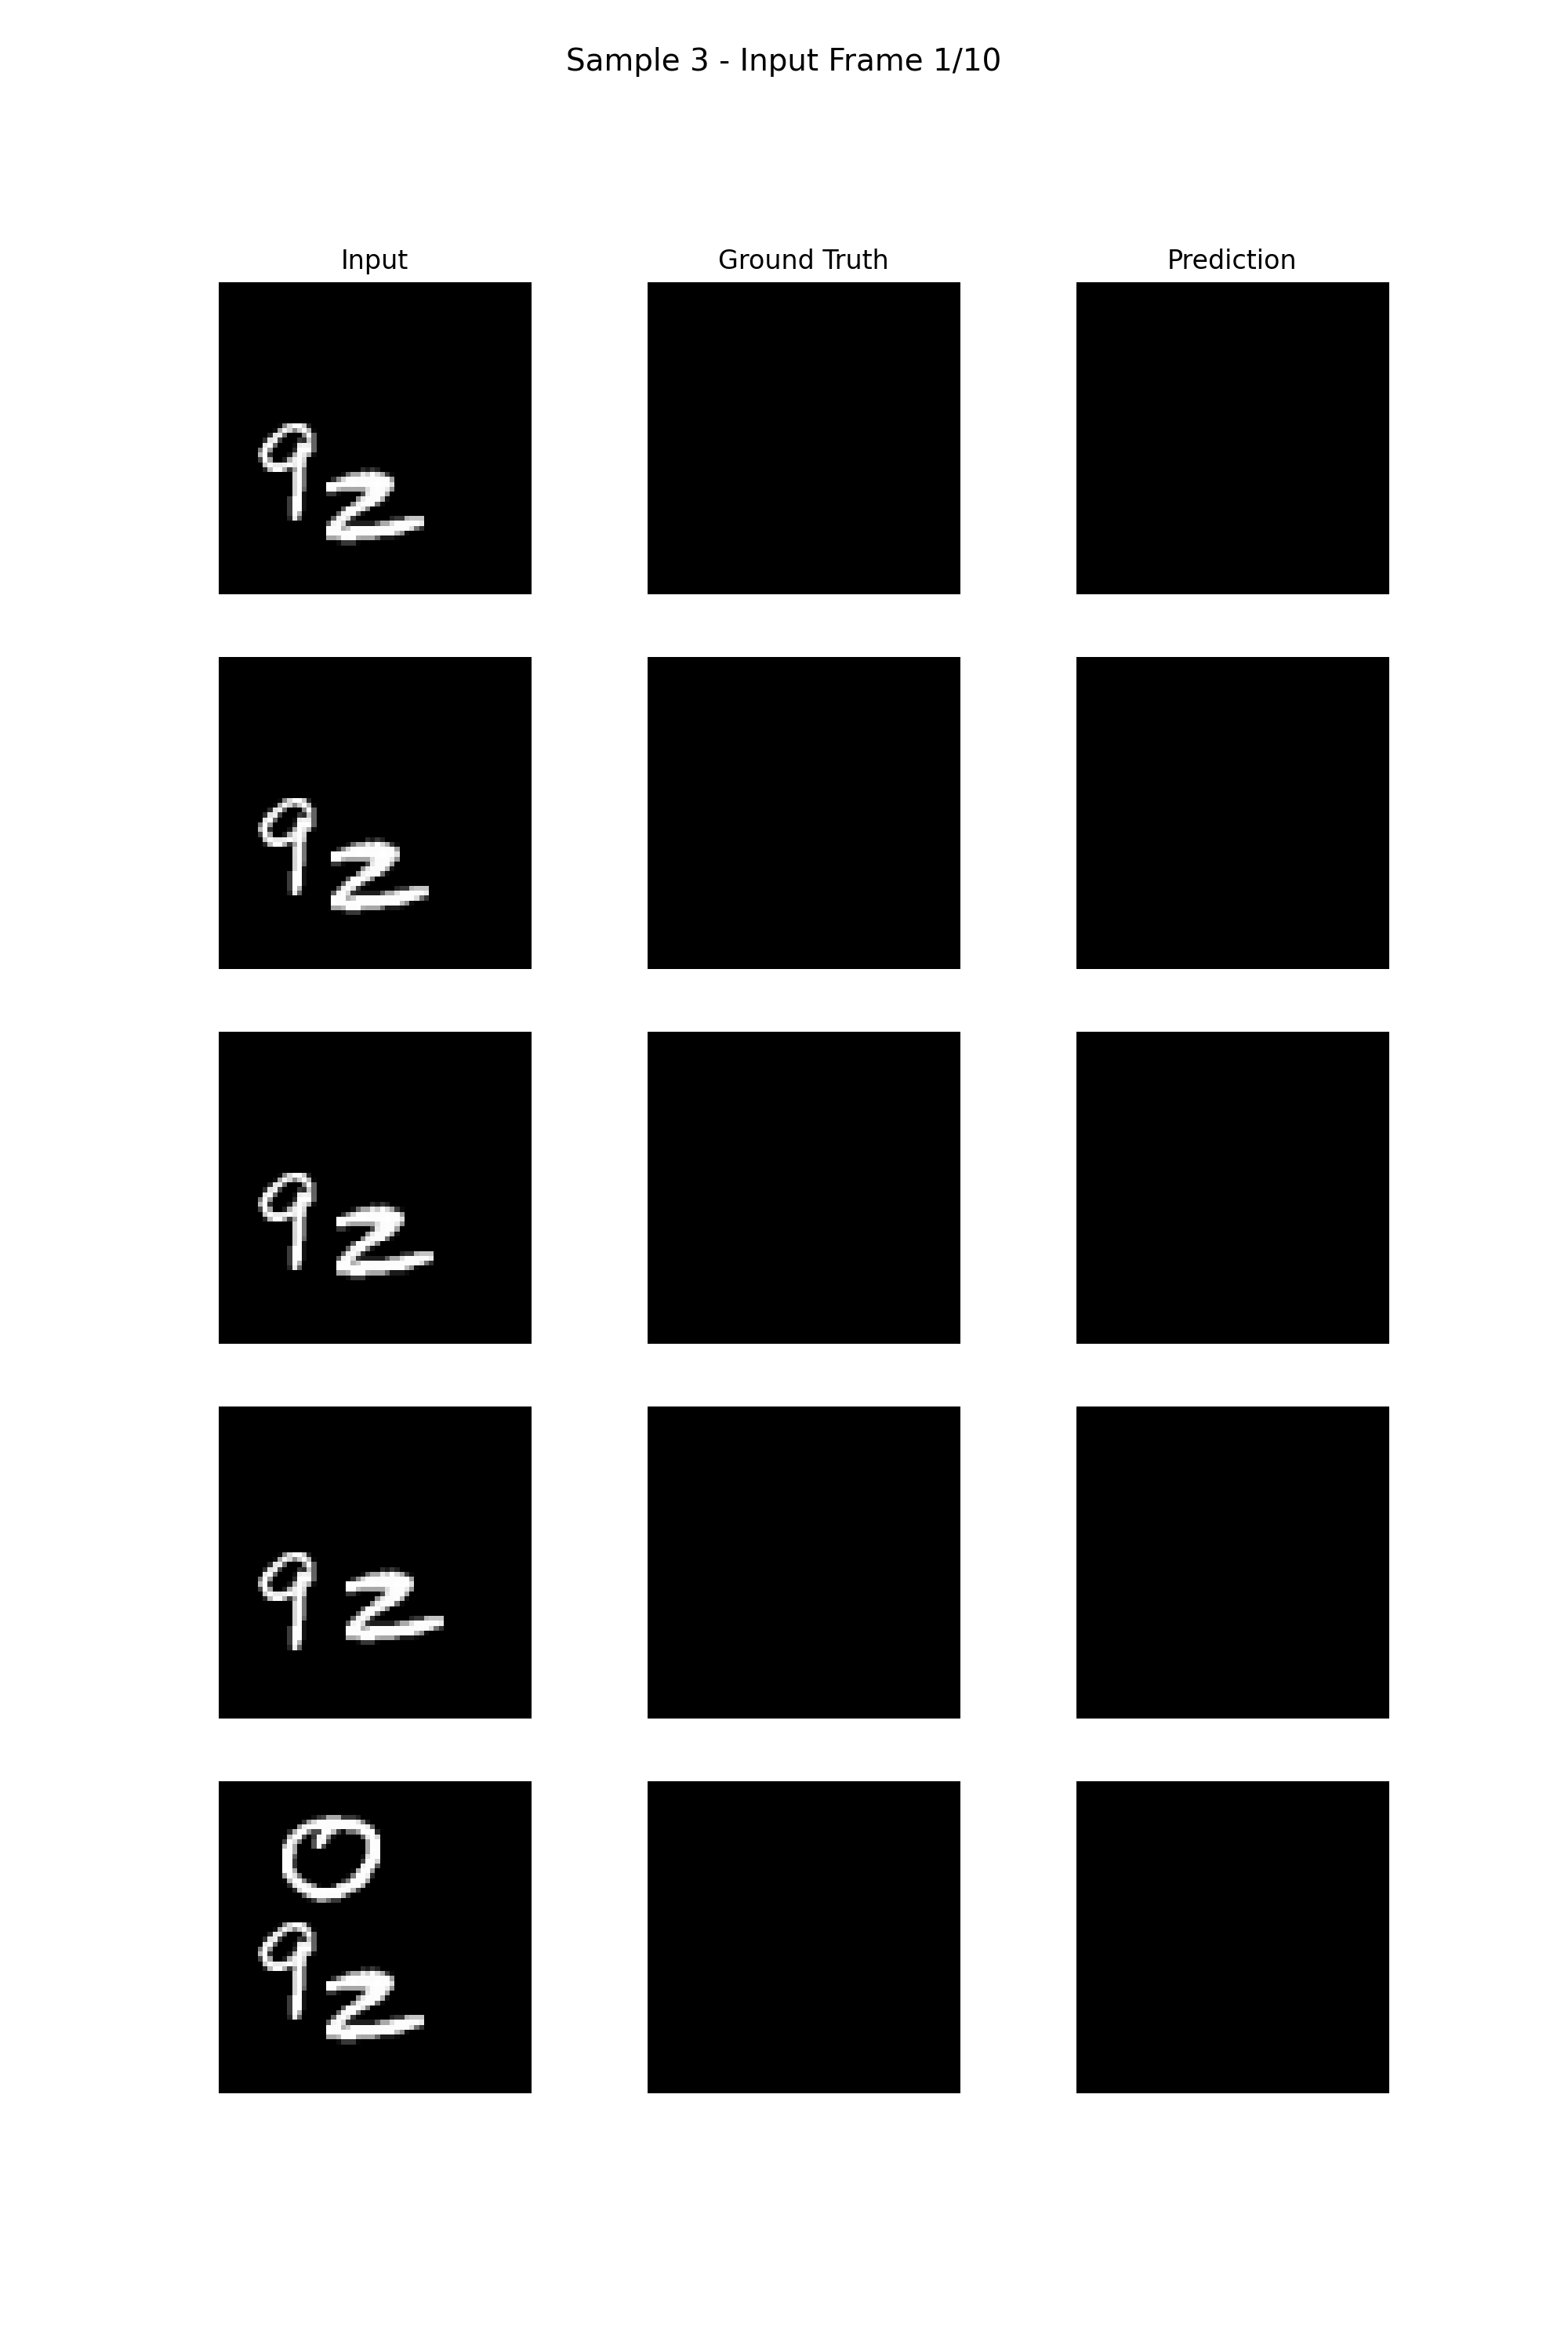

In [134]:
display(Image(filename='/Users/apple/git/neuro/OpenSTL/moving_mnist_zero_shot/results/same_sample_movies/same_sample_3_all_variants.gif'))

In [135]:
# Cell 9: Main Execution - Generate Samples
all_samples = create_all_variants_same_sample(num_samples=3)
save_dir = Path("moving_mnist_zero_shot/results/same_sample_movies")

Processing sample 1/3...


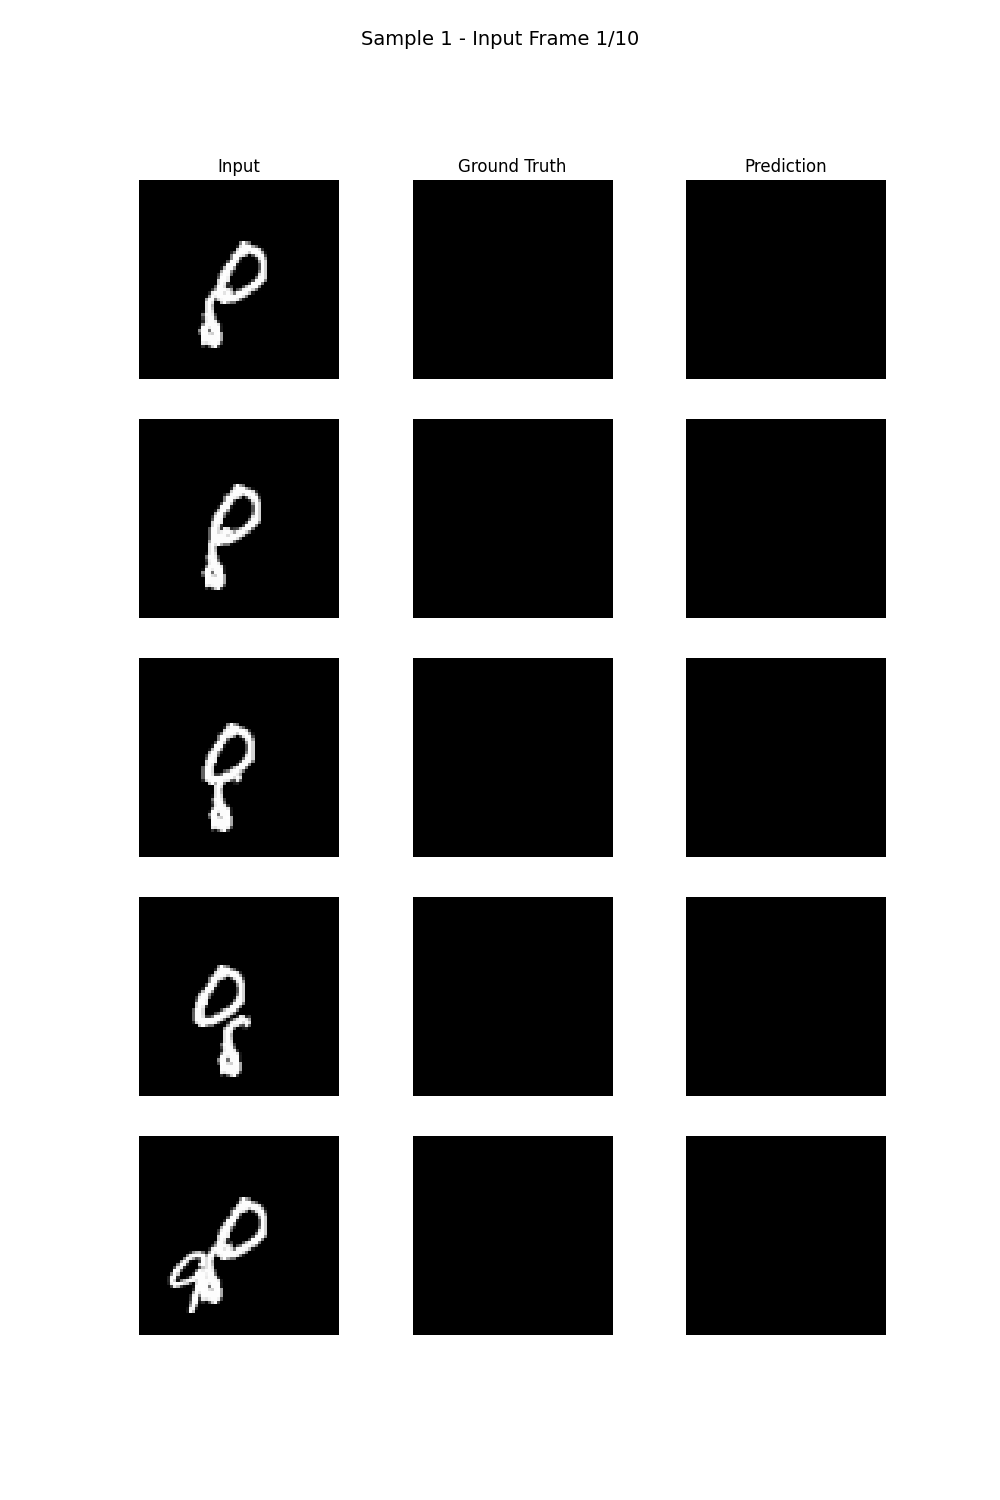

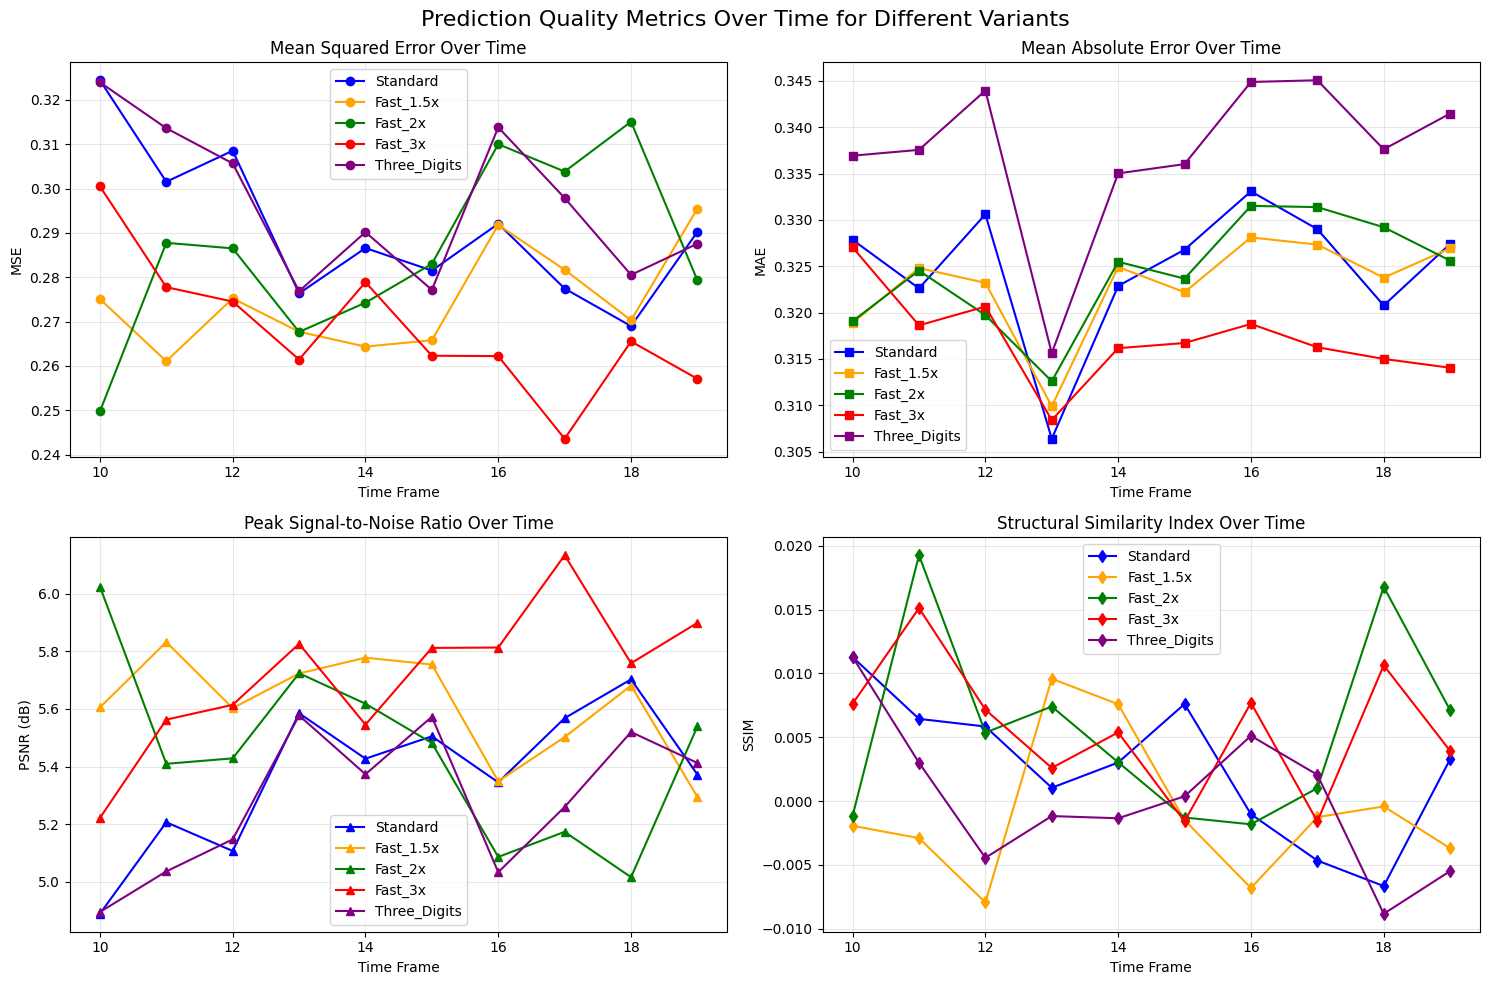

Processing sample 2/3...


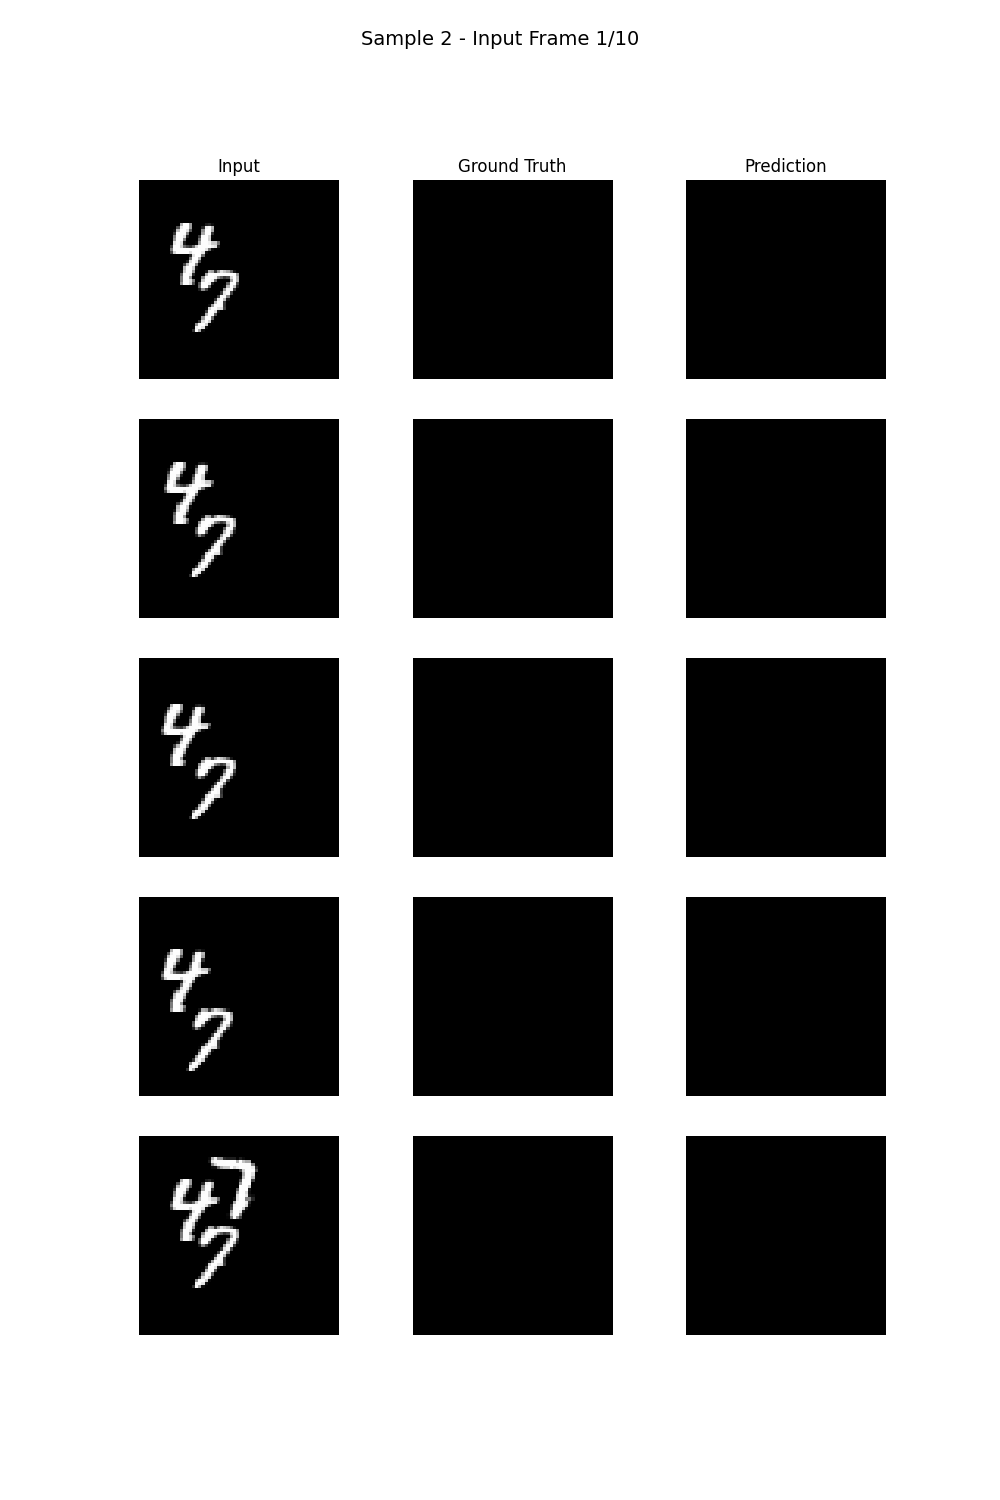

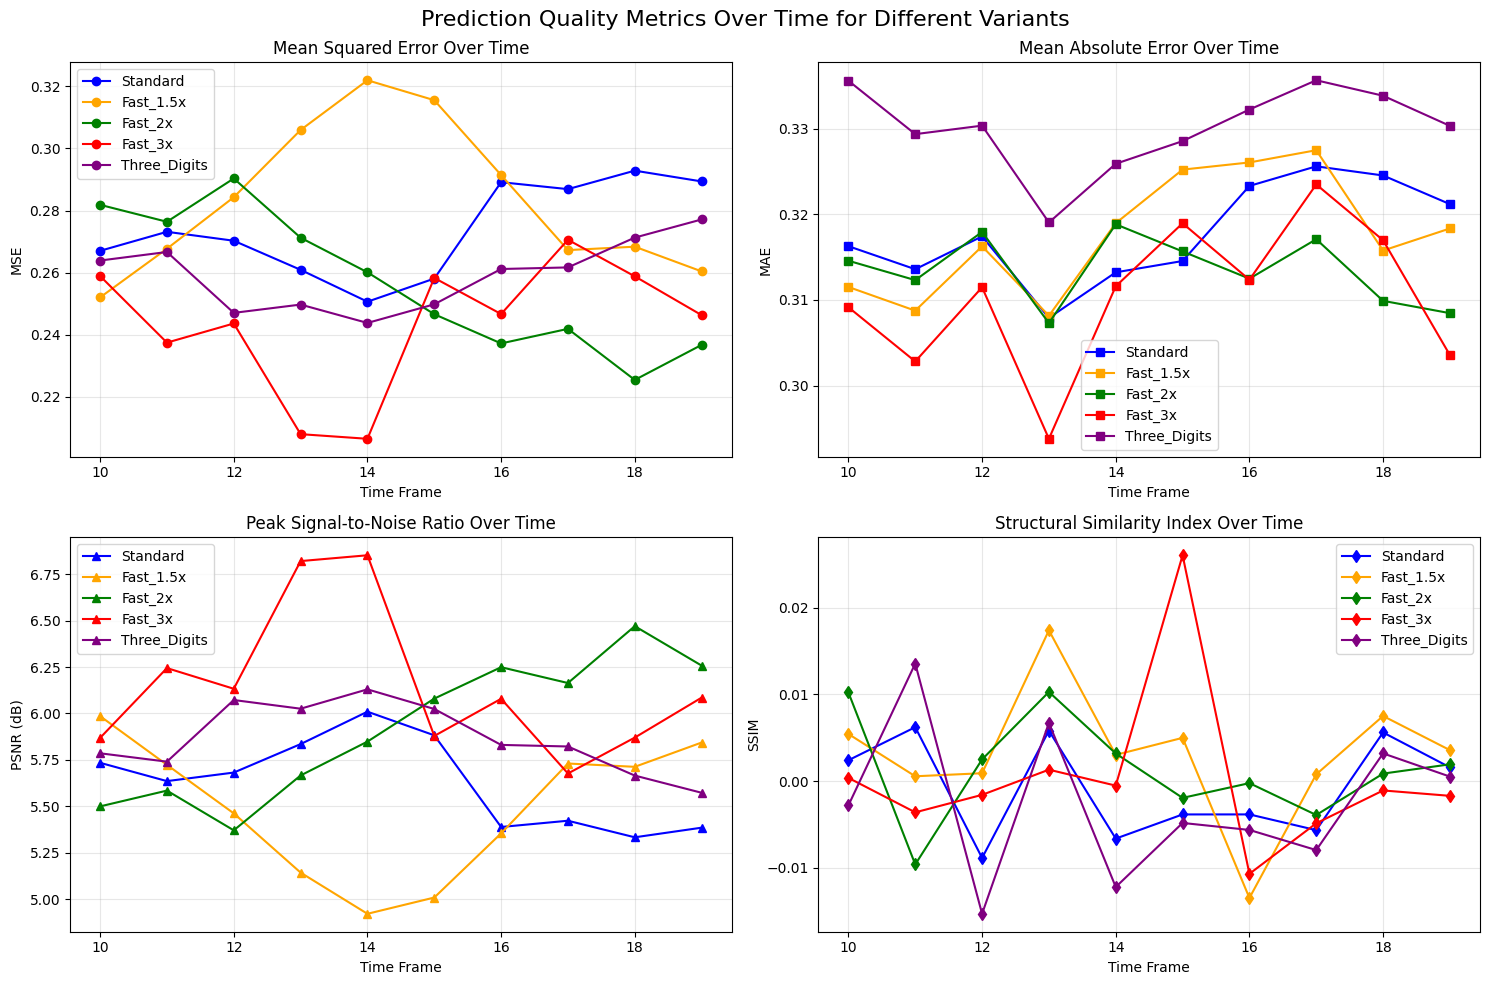

Processing sample 3/3...


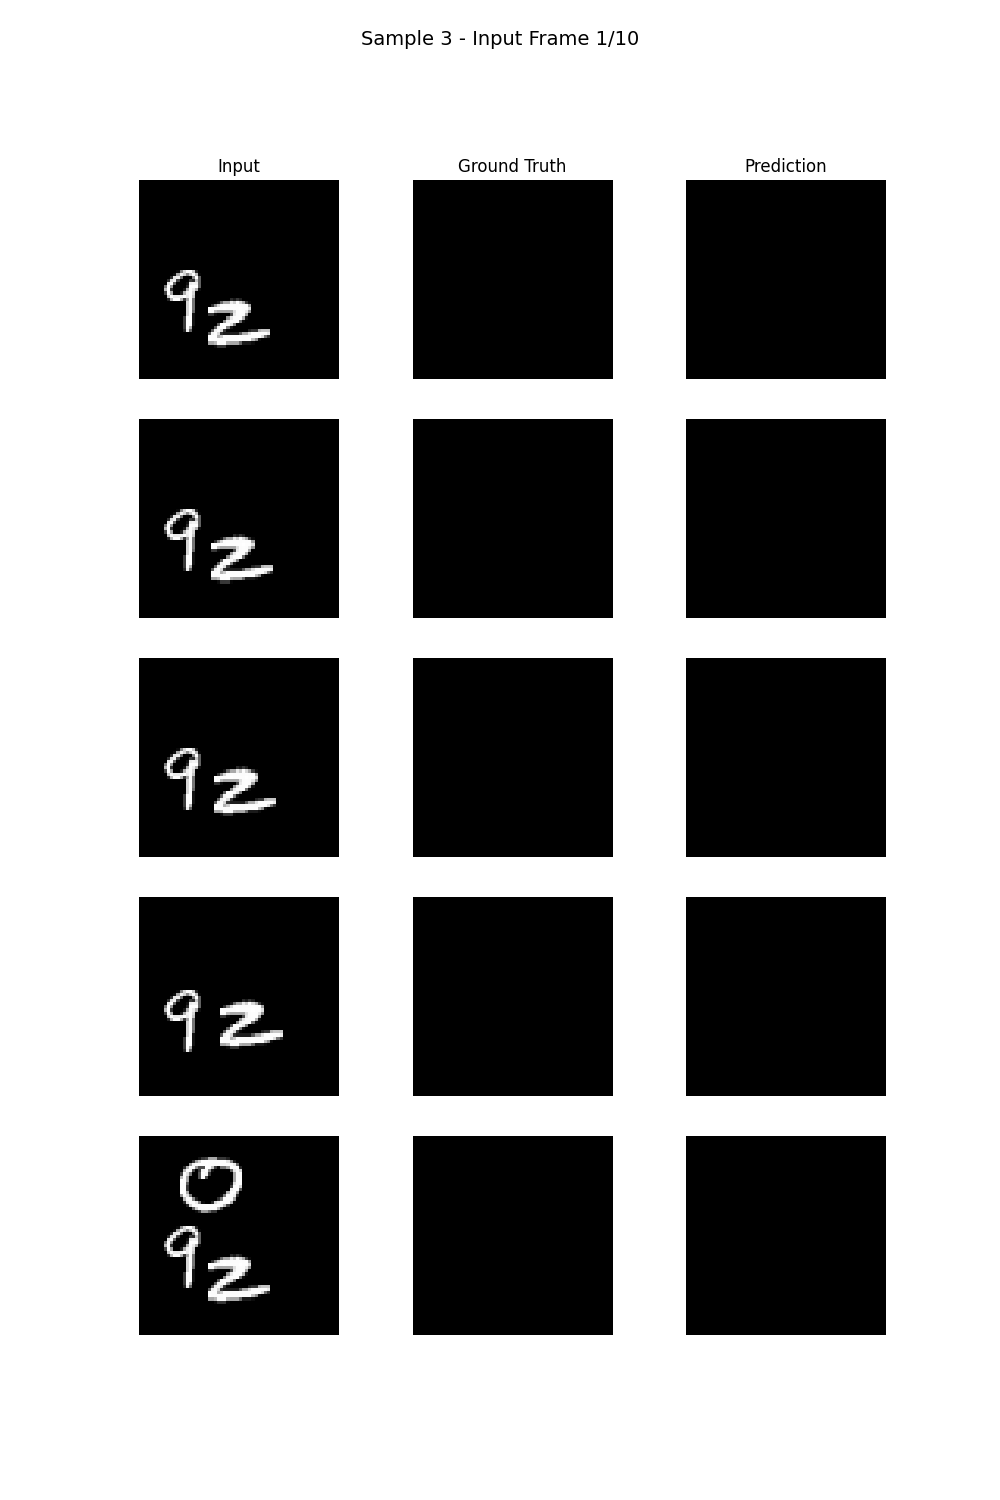

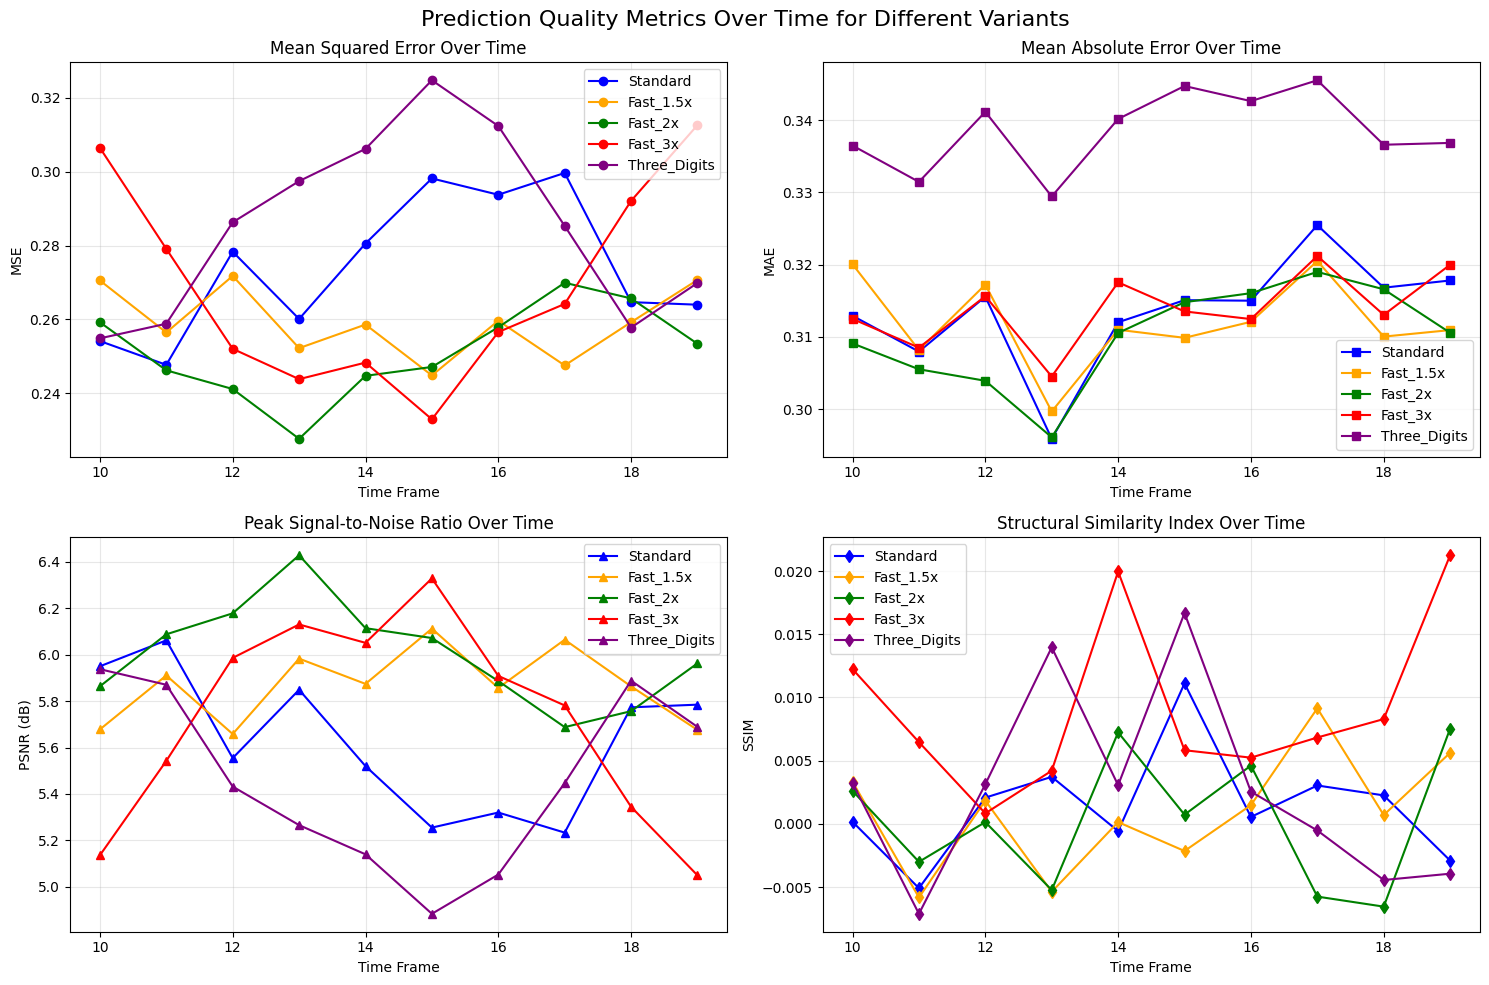

In [136]:
# Cell 10: Process Samples and Compute Metrics
all_metrics_by_sample = []

for sample_idx, sample_variants in enumerate(all_samples):
    print(f"Processing sample {sample_idx+1}/3...")
    
    # Get predictions and metrics
    predictions, metrics = evaluate_with_metrics(model, sample_variants)
    all_metrics_by_sample.append(metrics)
    
    # Create and display GIF
    gif_path = create_comparison_movie_with_metrics(model, sample_variants, sample_idx, save_dir)
    display(Image(filename=gif_path))
    
    # Plot metrics for this sample
    plot_metrics_over_time(metrics)

In [137]:
# Cell 11: Aggregate Metrics Across Samples
aggregated_metrics_by_variant = {}

for variant_name in all_metrics_by_sample[0].keys():
    variant_metrics_all_samples = []
    for sample_metrics in all_metrics_by_sample:
        variant_metrics_all_samples.append(sample_metrics[variant_name])
    
    aggregated_metrics_by_variant[variant_name] = aggregate_metrics(variant_metrics_all_samples)

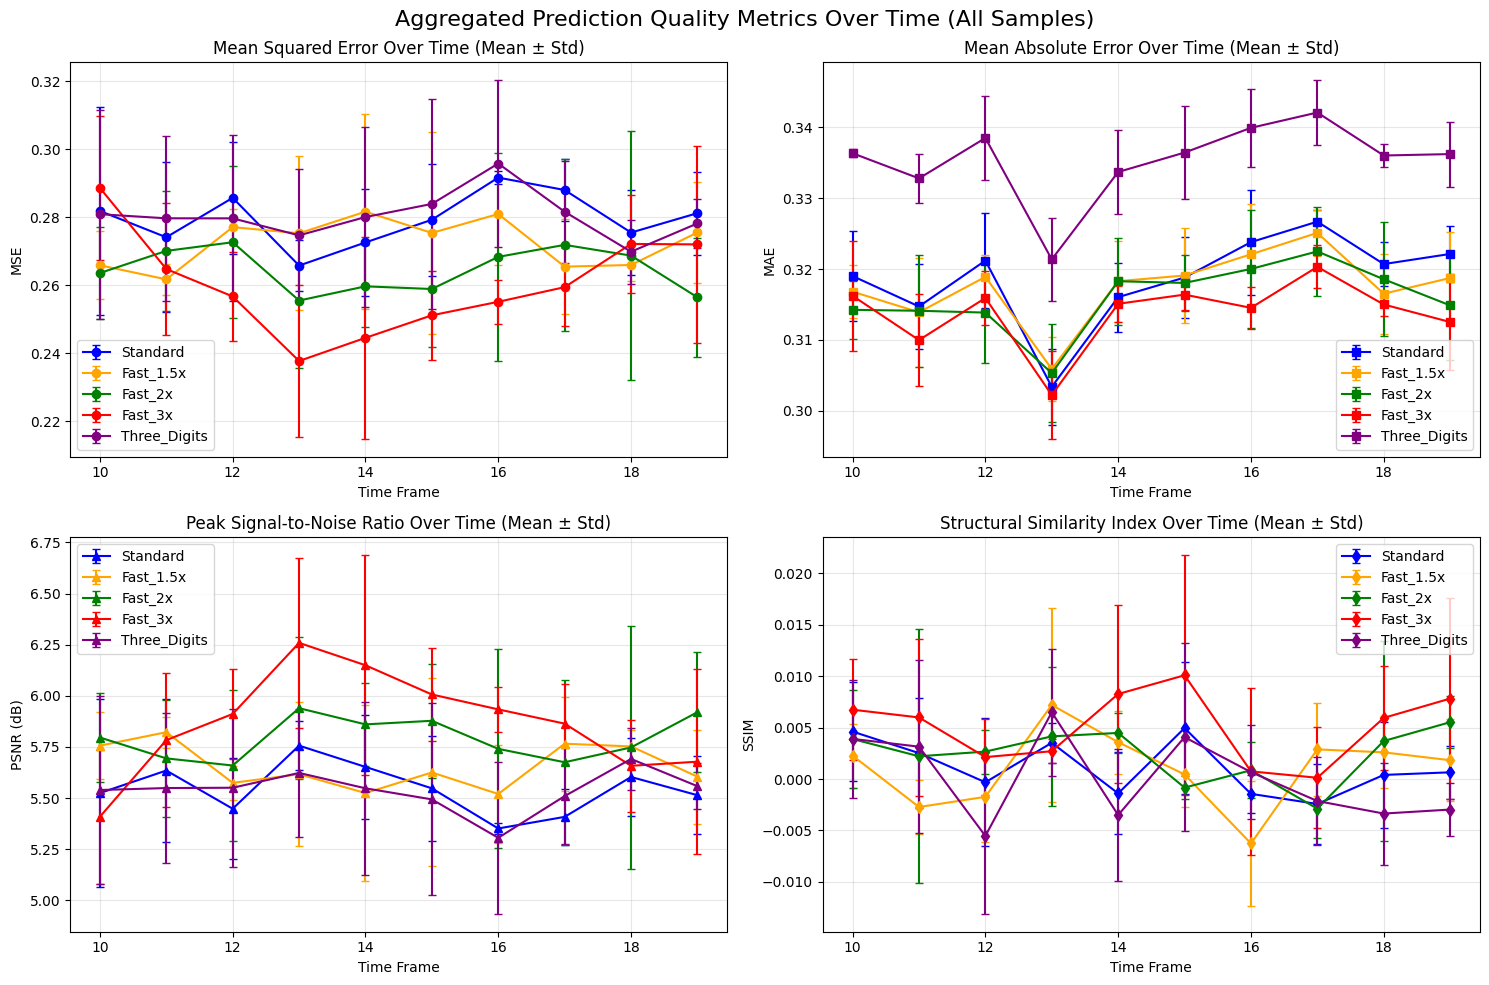

In [138]:
# Cell 12: Plot Aggregated Metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
frames = np.arange(10, 20)
colors = ['blue', 'orange', 'green', 'red', 'purple']

# MSE with error bars
ax = axes[0, 0]
for i, (variant_name, metrics) in enumerate(aggregated_metrics_by_variant.items()):
    ax.errorbar(frames, metrics['mse_mean'], yerr=metrics['mse_std'], 
                label=variant_name, color=colors[i], marker='o', capsize=3)
ax.set_xlabel('Time Frame')
ax.set_ylabel('MSE')
ax.set_title('Mean Squared Error Over Time (Mean ± Std)')
ax.legend()
ax.grid(True, alpha=0.3)

# MAE with error bars
ax = axes[0, 1]
for i, (variant_name, metrics) in enumerate(aggregated_metrics_by_variant.items()):
    ax.errorbar(frames, metrics['mae_mean'], yerr=metrics['mae_std'],
                label=variant_name, color=colors[i], marker='s', capsize=3)
ax.set_xlabel('Time Frame')
ax.set_ylabel('MAE')
ax.set_title('Mean Absolute Error Over Time (Mean ± Std)')
ax.legend()
ax.grid(True, alpha=0.3)

# PSNR with error bars
ax = axes[1, 0]
for i, (variant_name, metrics) in enumerate(aggregated_metrics_by_variant.items()):
    ax.errorbar(frames, metrics['psnr_mean'], yerr=metrics['psnr_std'],
                label=variant_name, color=colors[i], marker='^', capsize=3)
ax.set_xlabel('Time Frame')
ax.set_ylabel('PSNR (dB)')
ax.set_title('Peak Signal-to-Noise Ratio Over Time (Mean ± Std)')
ax.legend()
ax.grid(True, alpha=0.3)

# SSIM with error bars
ax = axes[1, 1]
for i, (variant_name, metrics) in enumerate(aggregated_metrics_by_variant.items()):
    ax.errorbar(frames, metrics['ssim_mean'], yerr=metrics['ssim_std'],
                label=variant_name, color=colors[i], marker='d', capsize=3)
ax.set_xlabel('Time Frame')
ax.set_ylabel('SSIM')
ax.set_title('Structural Similarity Index Over Time (Mean ± Std)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Aggregated Prediction Quality Metrics Over Time (All Samples)', fontsize=16)
plt.tight_layout()
plt.show()

In [139]:
# Cell 13: Summary Statistics
print("Average Metrics Across All Frames and Samples:")
print("="*60)

for variant_name, metrics in aggregated_metrics_by_variant.items():
    print(f"\n{variant_name}:")
    print(f"  MSE:  {np.mean(metrics['mse_mean']):.4f} ± {np.mean(metrics['mse_std']):.4f}")
    print(f"  MAE:  {np.mean(metrics['mae_mean']):.4f} ± {np.mean(metrics['mae_std']):.4f}")
    print(f"  PSNR: {np.mean(metrics['psnr_mean']):.2f} ± {np.mean(metrics['psnr_std']):.2f} dB")
    print(f"  SSIM: {np.mean(metrics['ssim_mean']):.4f} ± {np.mean(metrics['ssim_std']):.4f}")

Average Metrics Across All Frames and Samples:

Standard:
  MSE:  0.2796 ± 0.0144
  MAE:  0.3186 ± 0.0051
  PSNR: 5.54 ± 0.22 dB
  SSIM: 0.0011 ± 0.0042

Fast_1.5x:
  MSE:  0.2725 ± 0.0149
  MAE:  0.3175 ± 0.0054
  PSNR: 5.66 ± 0.23 dB
  SSIM: 0.0010 ± 0.0044

Fast_2x:
  MSE:  0.2646 ± 0.0212
  MAE:  0.3160 ± 0.0066
  PSNR: 5.79 ± 0.35 dB
  SSIM: 0.0024 ± 0.0047

Fast_3x:
  MSE:  0.2602 ± 0.0180
  MAE:  0.3138 ± 0.0043
  PSNR: 5.87 ± 0.30 dB
  SSIM: 0.0051 ± 0.0066

Three_Digits:
  MSE:  0.2804 ± 0.0212
  MAE:  0.3353 ± 0.0045
  PSNR: 5.54 ± 0.33 dB
  SSIM: 0.0001 ± 0.0060
